Estudio de Prophet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics.metrics import mape, mse, r2_score
from darts import concatenate
from darts.models.forecasting.arima import ARIMA
from darts.models import NBEATSModel

dfVentas = pd.read_csv('ventas.csv')
# Renombramos las columnas
columns_hash = {
    'Cantidad (en UM de inventario)': 'cantidad',
    'VentaNeta': 'venta_total',
    'CodCliente': 'cod_cliente',
    'Número de documento': 'n_boleta',
    'ItemCode': 'item_code',
    'CodVendedor': 'cod_vendedor',
    'Código de almacén de línea': 'cod_almacen',
    'Fecha': 'fecha',
    'Descripción del artículo': 'descripcion',
    'CanalDeVenta': 'canal_venta',
    'Kilombos': 'kilombos',
}
dfVentas.rename(columns=columns_hash, inplace=True)
# Quitamos los kilos negativos
dfVentas = dfVentas[dfVentas['kilombos'] > 0]
# Formateamos la fecha
dfVentas['ds'] = dfVentas['fecha'].apply(lambda date: pd.to_datetime(date, format='%d-%b-%y')).sort_values(ascending=True)
dfVentas['ds-monthYear'] = dfVentas['ds'].dt.strftime('%Y-%m')
dfVentas['ds-weekYear'] = dfVentas['ds'].dt.strftime('%Y-%U')
dfVentas.head()

Importing plotly failed. Interactive plots will not work.


,cantidad,venta_total,cod_cliente,n_boleta,item_code,cod_vendedor,cod_almacen,fecha,descripcion,canal_venta,kilombos,ds,ds-monthYear,ds-weekYear
0,30,58172.0,C77196968,1054011,100401405101,11,B30,5-Apr-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,6.0,2021-04-05,2021-04,2021-14
1,60,116345.0,C76047944,1065766,100401405101,4,B30,11-Aug-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0,2021-08-11,2021-08,2021-32
2,60,116344.0,C76047944,1071927,100401405101,4,B30,20-Oct-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0,2021-10-20,2021-10,2021-42
3,60,116345.0,T00000581,1044987,100401405101,38,B30,3-Nov-20,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0,2020-11-03,2020-11,2020-44
4,60,116345.0,T00000377,1055172,100401405101,38,B30,21-Apr-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,Televenta,12.0,2021-04-21,2021-04,2021-16


In [2]:
# Funcion para generar un df agrupado y con agregaciones básicas
def getGroupedData(df, groupBy, aggs = ['kilombos']):
    # Se genera el objetopara agregaciones
    agg = {}
    for col in aggs:
        # por cada columna se agrega una agregacion de los estadísticos básicos
        agg[col] = ['sum', 'max', 'min', 'mean', 'median', 'std']
    # Se agrupa el df
    newDf = df.groupby(groupBy).agg(agg)
    # Se renombra las columnas
    newDf.columns = ['_'.join(col).strip() for col in newDf.columns.values]
    # Se retorna el df
    return newDf

groupedWeeklyDf = getGroupedData(dfVentas, ['ds-weekYear', 'item_code'])

In [3]:
# Agrupamos los items
cranberriesItems = [140201405101, 140202405101, 140101110103, 140101110104, 140201408102, 140201409102, 140202408102, 140202409101, 140203409101]
cranberriesDf = dfVentas[dfVentas['item_code'].isin(cranberriesItems)]

In [4]:
# Generamos 
groupedDaily = getGroupedData(cranberriesDf, 'ds')
groupedMonthly = getGroupedData(cranberriesDf, 'ds-monthYear')
groupedWeekly = getGroupedData(cranberriesDf, 'ds-weekYear')

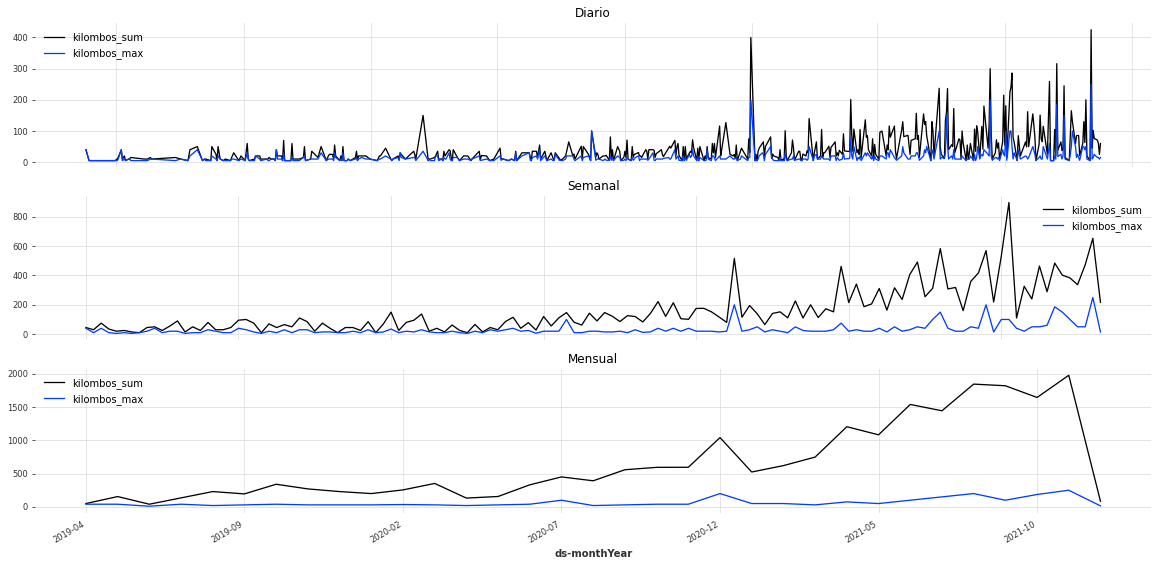

In [5]:
def plot_grouped(grouped, title, ax, cols=['kilombos_sum', 'kilombos_max', 'kilombos_min', 'kilombos_mean', 'kilombos_median']):
    for col in cols:
        grouped.plot(y=col, ax=ax)
    ax.set_title(title)

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
plot_grouped(groupedDaily, 'Diario', ax[0], ['kilombos_sum', 'kilombos_max'])
plot_grouped(groupedWeekly, 'Semanal', ax[1], ['kilombos_sum', 'kilombos_max'])
plot_grouped(groupedMonthly, 'Mensual', ax[2], ['kilombos_sum', 'kilombos_max'])

fig.autofmt_xdate()

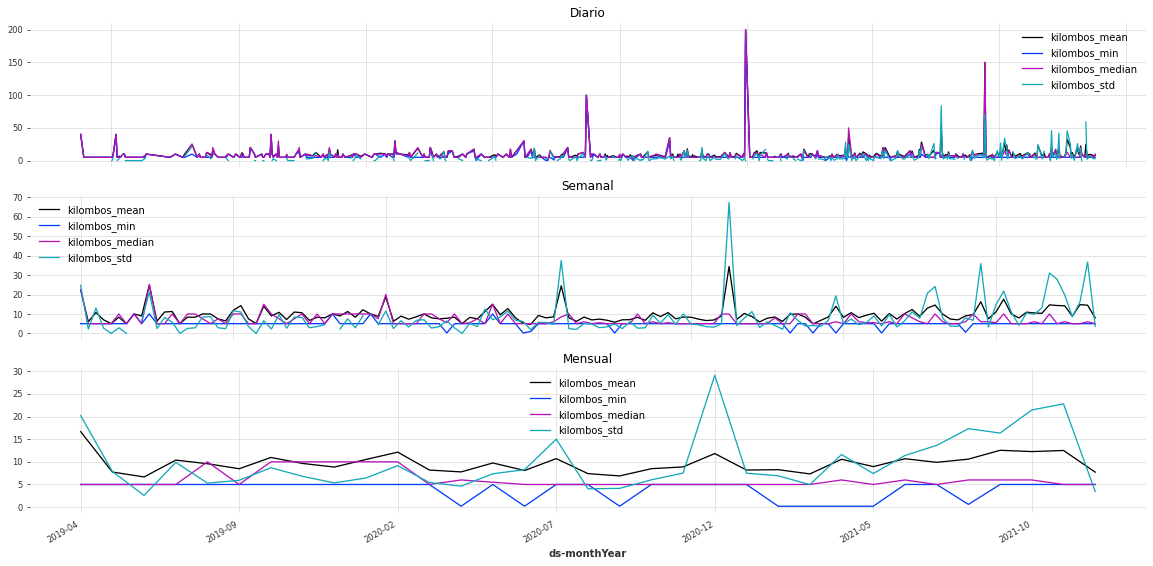

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
plot_grouped(groupedDaily, 'Diario', ax[0], ['kilombos_mean', 'kilombos_min', 'kilombos_median', 'kilombos_std'])
plot_grouped(groupedWeekly, 'Semanal', ax[1], ['kilombos_mean', 'kilombos_min', 'kilombos_median', 'kilombos_std'])
plot_grouped(groupedMonthly, 'Mensual', ax[2], ['kilombos_mean', 'kilombos_min', 'kilombos_median', 'kilombos_std'])
fig.autofmt_xdate()

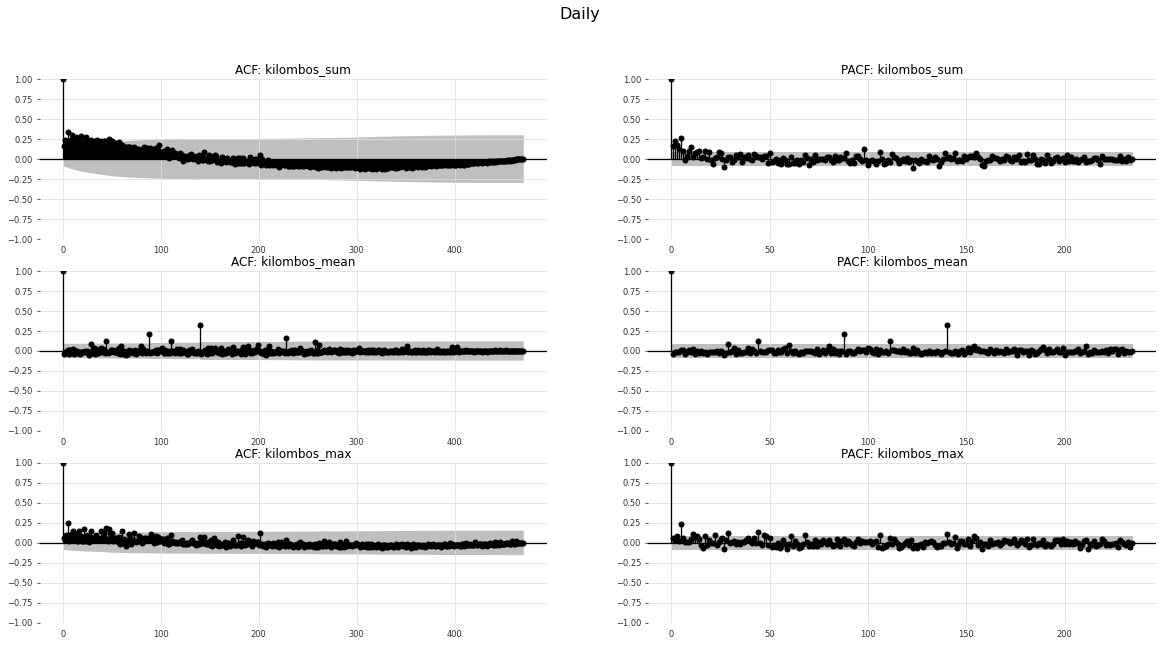

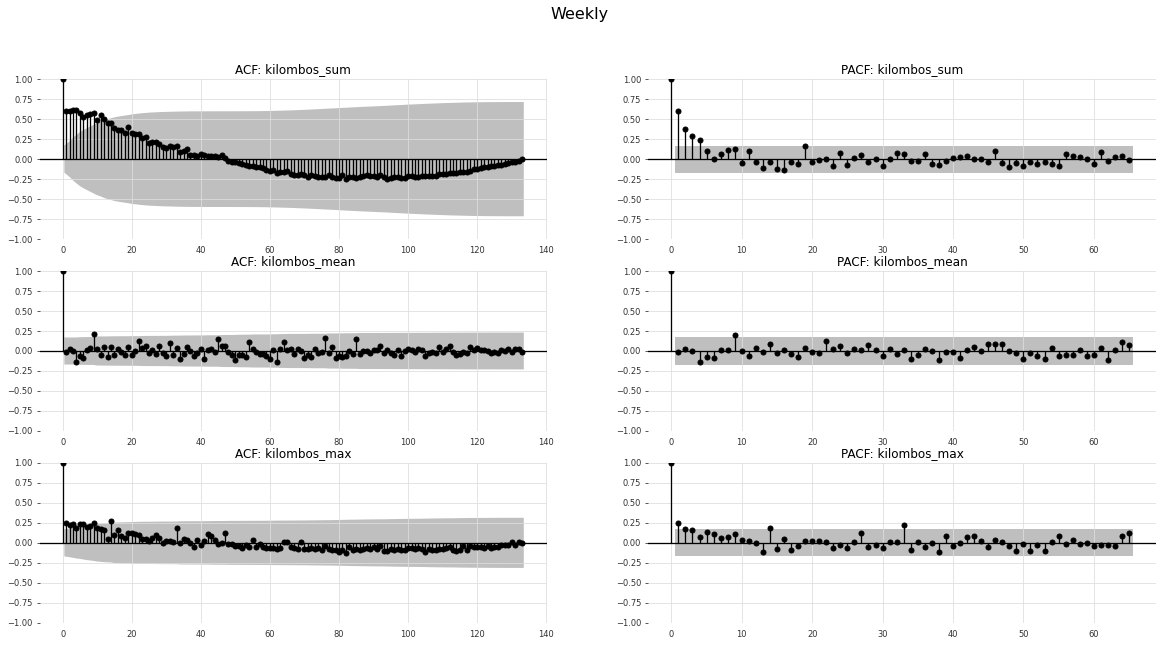

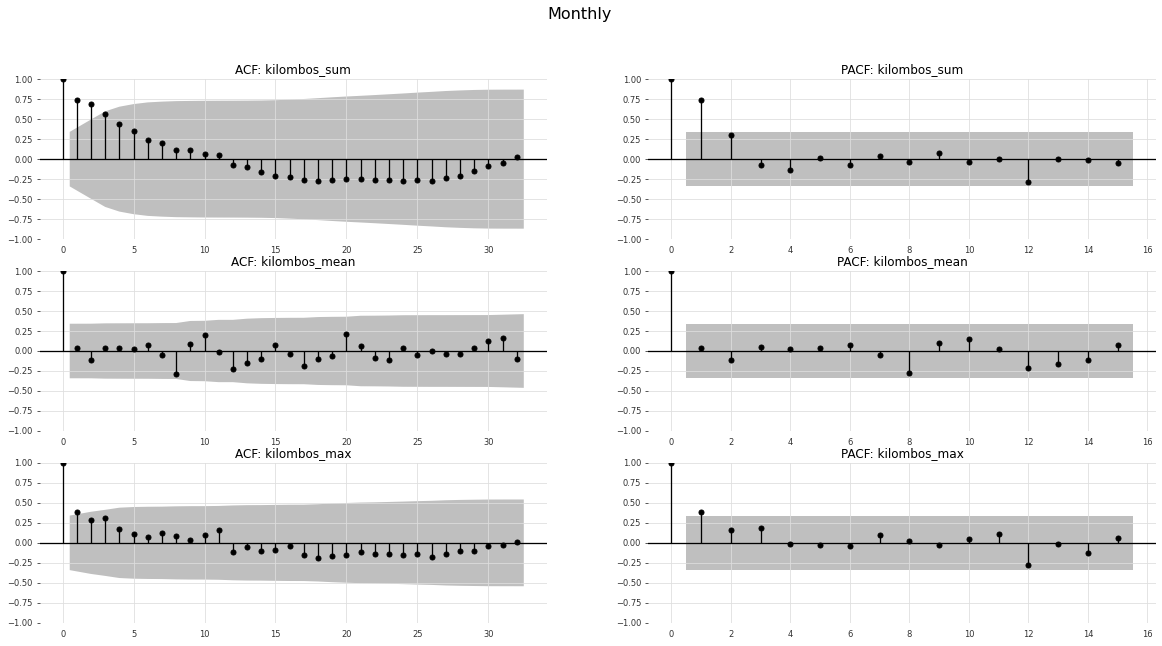

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

def plot_correlations(df, columns, title):
    fig, ax = plt.subplots(len(columns), 2, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)
    for i, column in enumerate(columns):
        lag = df[column].shape[0] - 1 
        plot_acf(df[column], lags=lag, ax=ax[i, 0])
        ax[i, 0].set_title('ACF: ' + column)
        plot_pacf(df[column], lags=math.floor(lag/2) - 1 , ax=ax[i, 1], method='ywm')
        ax[i, 1].set_title('PACF: ' + column)

plot_correlations(groupedDaily, ['kilombos_sum', 'kilombos_mean', 'kilombos_max'], 'Daily')
plot_correlations(groupedWeekly, ['kilombos_sum', 'kilombos_mean', 'kilombos_max'], 'Weekly')
plot_correlations(groupedMonthly, ['kilombos_sum', 'kilombos_mean', 'kilombos_max'], 'Monthly')

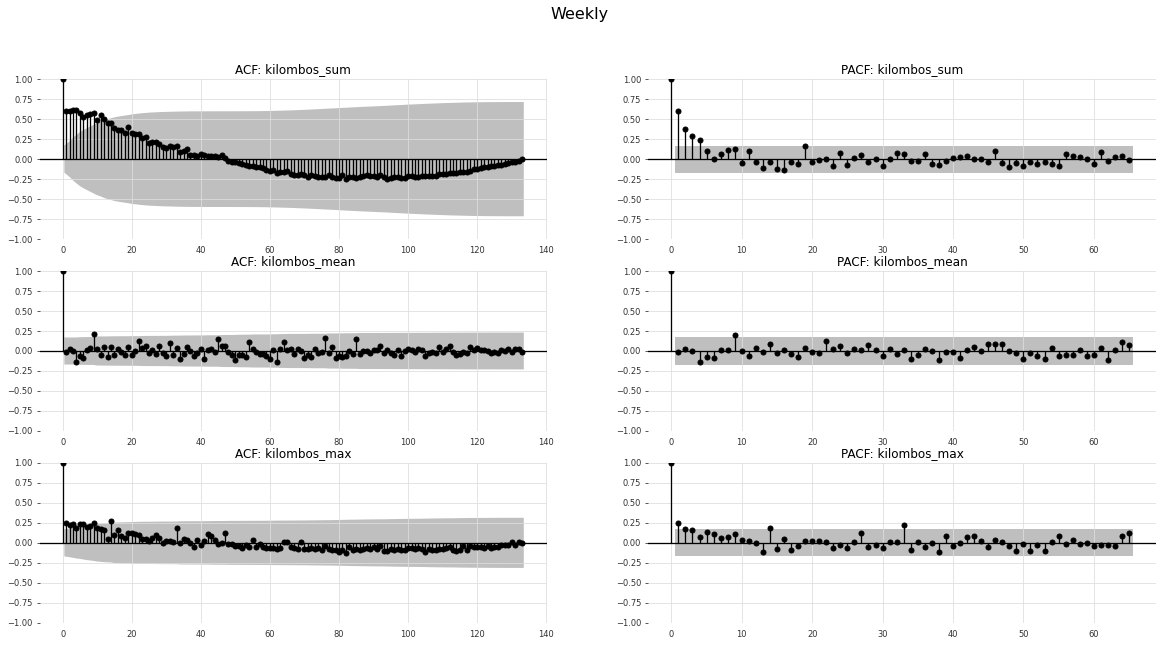

In [8]:
import datetime
filteredDf = cranberriesDf[cranberriesDf['ds'] < datetime.datetime(2022, 12, 1)].groupby('ds-weekYear').agg({'kilombos': ['sum', 'max', 'min', 'mean'], 'cod_cliente': 'nunique', 'cod_vendedor': 'nunique'})
filteredDf.columns = ['_'.join(col).strip() for col in filteredDf.columns.values]
plot_correlations(filteredDf, ['kilombos_sum', 'kilombos_mean', 'kilombos_max'], 'Weekly')

In [9]:
# Transformamos las fechas de cada semana a pd.Int64Index
def convertWeeklyIndex(df):
    # Desde 2019-13 a 2021-48 hay 134 semanas
    año = 2019
    semana = 13
    index = 1
    indexes = []
    debugLabels = []
    while True:
        cero = '0' if semana < 10 else ''
        label = f'{año}-{cero}{semana}'
        if label in df.index:
            debugLabels.append(label)
            indexes.append(index)
        if label == '2021-48':
            break
        index += 1
        semana += 1
        if semana == 54:
            semana = 0
            año += 1
    # Creamos un nuevo DataFrame con las fechas de las semanas

    newIndex = pd.Int64Index(indexes)
    intWeekly = df.copy()
    try :
        intWeekly.index = newIndex
    except:
        # Buscar el index en df que no esta en debugLabels
        notFound = list(filter(lambda x: x not in debugLabels, df.index))
        print(notFound)
    return intWeekly

intWeekly = convertWeeklyIndex(groupedWeekly)


In [10]:
intWeekly.head(5)

,kilombos_sum,kilombos_max,kilombos_min,kilombos_mean,kilombos_median,kilombos_std
1,45.0,40.0,5.0,22.500000,22.5,24.748737
5,30.0,10.0,5.0,6.000000,5.0,2.236068
6,75.0,40.0,5.0,10.714286,5.0,13.047532
7,35.0,10.0,5.0,7.000000,5.0,2.738613
9,20.0,5.0,5.0,5.000000,5.0,0.000000


In [11]:
import math
def getSeparationIndex(df, frac=0.8):
    separationIndex = math.floor(len(df.index) * frac)
    print(f'Separation index: {df.index[separationIndex]}')
    return df.index[separationIndex]

## ARIMA MODELS

### Daily

Separation index: 2021-07-12 00:00:00


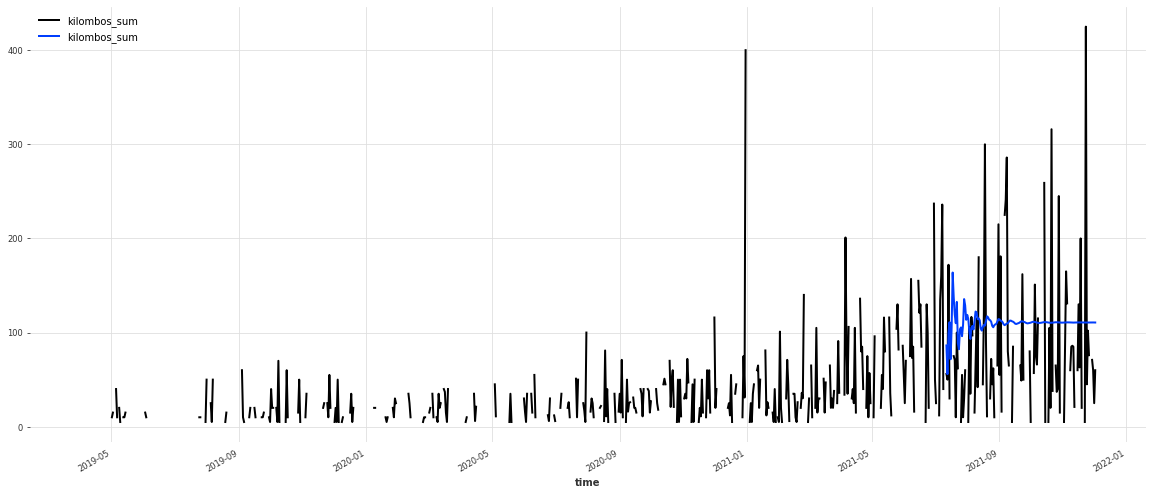

In [12]:
dailySeries = TimeSeries.from_dataframe(groupedDaily, None, value_cols=['kilombos_sum', 'kilombos_mean', 'kilombos_max', 'kilombos_median', 'kilombos_std'], freq='D')
# Separamos los datos en train y test
train, test = dailySeries.split_before(getSeparationIndex(groupedDaily))
# Creamos una instancia de ARIMA
arima = ARIMA()
# Ajustamos el modelo
arima.fit(train['kilombos_sum'])
# Predecimos
predictions = arima.predict(len(test))
# Graficamos
plt.figure(figsize=(20, 8))
dailySeries['kilombos_sum'].plot()
predictions.plot()

### Semanal

In [28]:
# Creamos una instancia de TimeSeries
series = TimeSeries.from_dataframe(intWeekly, None, value_cols=['kilombos_sum', 'kilombos_mean', 'kilombos_max', 'kilombos_median'], freq='W')
# Separamos los datos en train y test
train, test = series.split_before(getSeparationIndex(intWeekly))

Separation index: 118


D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


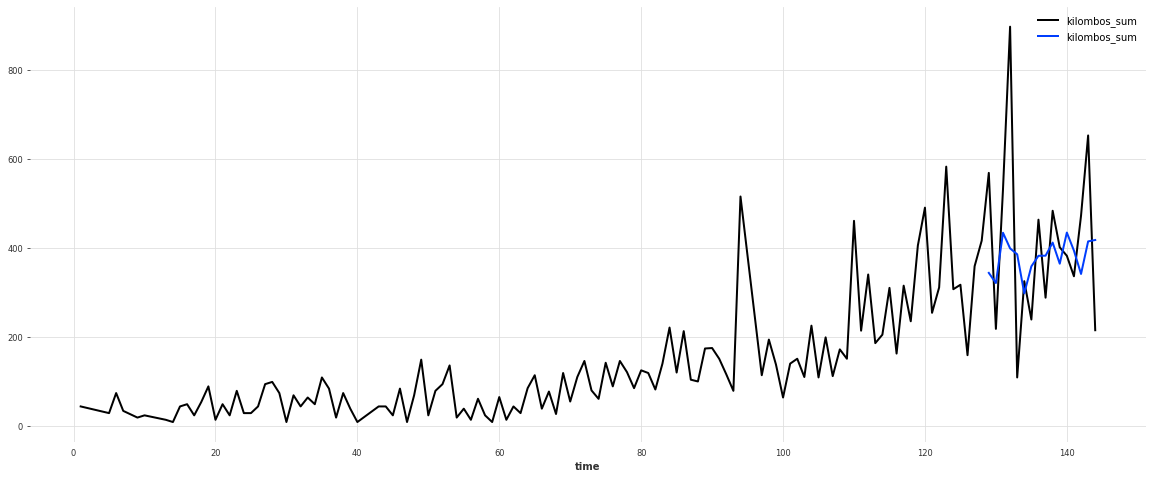

In [32]:
# Creamos una instancia de ARIMA
arima = ARIMA(p=8, d=1, q=2, seasonal_order=(1, 1, 1, 52))
# Ajustamos el modelo
arima.fit(train['kilombos_sum'])
# Predecimos
predictions = arima.predict(len(test))
# Graficamos
plt.figure(figsize=(20, 8))
series['kilombos_sum'].plot()
predictions.plot()



In [33]:
s = getSeparationIndex(train.pd_dataframe())
pre_train, pre_test = train.split_before(s)

Separation index: 105


In [36]:
best_model, params = arima.gridsearch({
    'p': np.arange(4,18,1, dtype=int),
    'd': np.arange(0,3,1, dtype=int),
    'q': np.arange(0,8,1, dtype=int),
}, pre_train['kilombos_sum'], val_series=pre_test['kilombos_sum'], verbose=False, n_jobs=-1)

[2022-03-01 21:57:28,531] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'p': 8, 'd': 2, 'q': 0}
[2022-03-01 21:57:28,531] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'p': 8, 'd': 2, 'q': 0}


D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


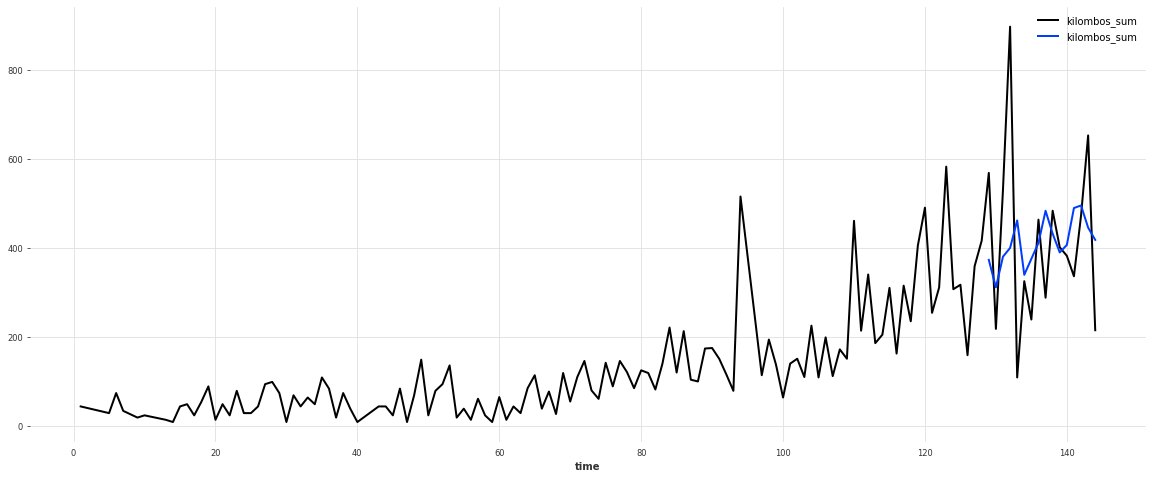

In [35]:
# Predecimos
best_model.fit(train['kilombos_sum'])
predictions = best_model.predict(len(test))
# Graficamos
plt.figure(figsize=(20, 8))
series['kilombos_sum'].plot()
predictions.plot()

## Regresión

[2022-03-01 19:41:07,899] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'lags': 10}
[2022-03-01 19:41:07,899] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'lags': 10}


{'lags': 10}


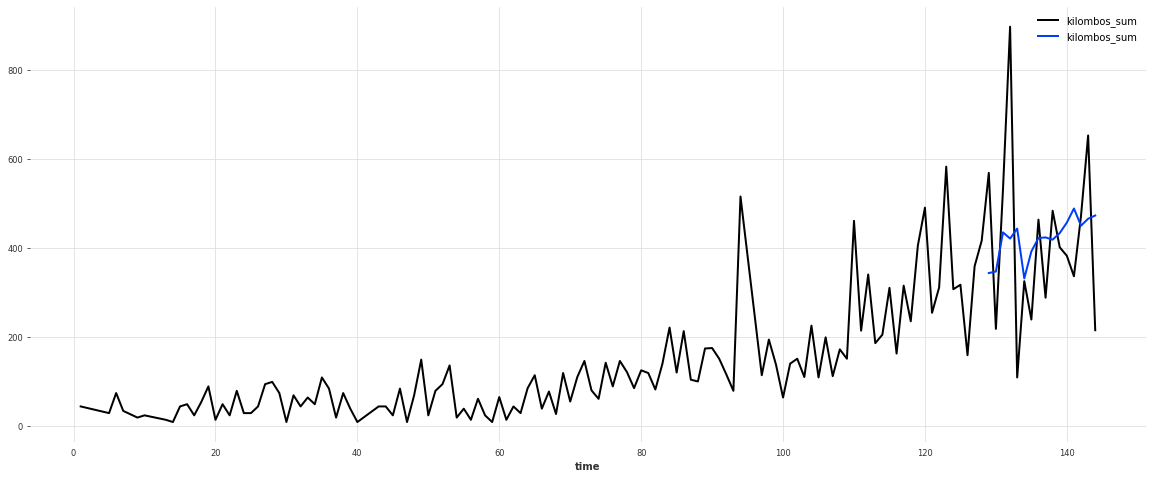

In [18]:
from darts.models.forecasting.regression_model import RegressionModel

# Creamos una instancia de RegressionModel
regression = RegressionModel(lags=1)
# Ajustamos el modelo
best_model, params = regression.gridsearch({
    'lags': [int(i + 1) for i in range(30)],
}, pre_train['kilombos_sum'], val_series=pre_test['kilombos_sum'], verbose=False, n_jobs=-1)
print(params)
best_model.fit(train['kilombos_sum'])
# Predecimos
predictions = best_model.predict(len(test))
# Graficamos
plt.figure(figsize=(20, 8))
series['kilombos_sum'].plot()
predictions.plot()


## N-BEATS

In [19]:
dfVentas['ds-weekYear'].sort_values().unique()

array(['2019-13', '2019-16', '2019-17', '2019-18', '2019-19', '2019-20',
       '2019-21', '2019-22', '2019-23', '2019-24', '2019-25', '2019-26',
       '2019-27', '2019-28', '2019-29', '2019-30', '2019-31', '2019-32',
       '2019-33', '2019-34', '2019-35', '2019-36', '2019-37', '2019-38',
       '2019-39', '2019-40', '2019-41', '2019-42', '2019-43', '2019-44',
       '2019-45', '2019-46', '2019-47', '2019-48', '2019-49', '2019-50',
       '2019-51', '2019-52', '2020-00', '2020-01', '2020-02', '2020-03',
       '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
       '2020-10', '2020-11', '2020-12', '2020-13', '2020-14', '2020-15',
       '2020-16', '2020-17', '2020-18', '2020-19', '2020-20', '2020-21',
       '2020-22', '2020-23', '2020-24', '2020-25', '2020-26', '2020-27',
       '2020-28', '2020-29', '2020-30', '2020-31', '2020-32', '2020-33',
       '2020-34', '2020-35', '2020-36', '2020-37', '2020-38', '2020-39',
       '2020-40', '2020-41', '2020-42', '2020-43', 

In [20]:
# Agrupamos según fecha e item
groupedWeeklyDf = dfVentas.groupby(['ds-weekYear', 'item_code']).agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedWeeklyDf.columns = ['_'.join(col).strip() for col in groupedWeeklyDf.columns.values]
# Escalamos la serie
scaler = Scaler()
filler = MissingValuesFiller(fill=0.5)
seriesByItemWeekly = {
    'train': {
        'target': [],
        'past_covars': [],
    },
    'test': {
        'target': [],
        'past_covars': [],
    }
}
for itemCode in groupedWeeklyDf.index.get_level_values(1).unique():
    subDf = groupedWeeklyDf[groupedWeeklyDf.index.get_level_values(1) == itemCode].sort_values(by='ds-weekYear')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        # Convertimos los indices a pd.Int64Index
        subDf = convertWeeklyIndex(subDf)
        itemTimeSeries = TimeSeries.from_dataframe(subDf, None, value_cols=['kilombos_sum', 'kilombos_mean', 'kilombos_max', 'kilombos_median', 'kilombos_std'], freq='W')
        # Completamos los datos faltantes
        itemTimeSeries = filler.transform(itemTimeSeries)
        # Escalamos la serie
        # itemTimeSeries = scaler.fit_transform(itemTimeSeries)
        # Separamos los datos en train y test
        train, test = itemTimeSeries.split_before(0.8)
        # Separamos las covariantes
        scaled_train_covs = concatenate(
            [
                train['kilombos_max'],
                train['kilombos_mean'],
                train['kilombos_median'],
                train['kilombos_std'],
            ],
            axis="component",
        )
        scaled_test_covs = concatenate(
            [
                test['kilombos_max'],
                test['kilombos_mean'],
                test['kilombos_median'],
                test['kilombos_std'],
            ],
            axis="component",
        )
        # Agregamos los datos al diccionario
        seriesByItemWeekly['train']['target'].append(train['kilombos_sum'])
        seriesByItemWeekly['train']['past_covars'].append(scaled_train_covs)
        seriesByItemWeekly['test']['target'].append(test['kilombos_sum'])
        seriesByItemWeekly['test']['past_covars'].append(scaled_test_covs)

In [21]:
# Entrenamos un NBEATS
model = NBEATSModel(input_chunk_length=5, output_chunk_length=5, random_state=42)
model.fit(
    seriesByItemWeekly['train']['target'],
    past_covariates=seriesByItemWeekly['train']['past_covars'],
    val_series=seriesByItemWeekly['test']['target'],
    val_past_covariates=seriesByItemWeekly['test']['past_covars'],
    epochs=50, verbose=True)

[2022-03-01 19:41:08,515] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1152 samples.
[2022-03-01 19:41:08,515] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1152 samples.
[2022-03-01 19:41:08,786] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-01 19:41:08,786] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Agrupamos según fecha e item
groupedDailyDf = dfVentas.groupby(['ds', 'item_code']).agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedDailyDf.columns = ['_'.join(col).strip() for col in groupedDailyDf.columns.values]
# Reemplazamos los valores faltantes
filler = MissingValuesFiller(fill=0.)
# Escalamos la serie
scaler = Scaler()

seriesByItem = {
    'train': {
        'target': [],
        'past_covars': [],
    },
    'test': {
        'target': [],
        'past_covars': [],
    }
}
for itemCode in groupedDailyDf.index.get_level_values(1).unique():
    subDf = groupedDailyDf[groupedDailyDf.index.get_level_values(1) == itemCode].sort_values(by='ds')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        itemTimeSeries = TimeSeries.from_dataframe(subDf, None, value_cols=['kilombos_sum', 'kilombos_std', 'kilombos_max', 'kilombos_median'], freq='D')
        # Completamos valores faltantes
        itemTimeSeries = filler.transform(itemTimeSeries)
        # Escalamos la serie
        scaled_series = scaler.fit_transform(itemTimeSeries)
        # Separamos los datos en train y test
        train, test = scaled_series.split_before(0.8)
        # Separamos las covariantes
        scaled_train_covs = concatenate(
            [
                train['kilombos_max'],
                train['kilombos_std'],
                train['kilombos_median'],
            ],
            axis="component",
        )
        scaled_test_covs = concatenate(
            [
                test['kilombos_max'],
                test['kilombos_std'],
                test['kilombos_median'],
            ],
            axis="component",
        )
        # Agregamos los datos al diccionario
        seriesByItem['train']['target'].append(train['kilombos_sum'])
        seriesByItem['train']['past_covars'].append(scaled_train_covs)
        seriesByItem['test']['target'].append(test['kilombos_sum'])
        seriesByItem['test']['past_covars'].append(scaled_test_covs)

In [ ]:
# Entrenamos un NBEATS
model = NBEATSModel(input_chunk_length=60, output_chunk_length=30, random_state=42)
model.fit(
    seriesByItem['train']['target'],
    past_covariates=seriesByItem['train']['past_covars'],
    val_series=seriesByItem['test']['target'],
    val_past_covariates=seriesByItem['test']['past_covars'],
    epochs=50, verbose=True)

[2022-02-22 17:25:52,805] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 8292 samples.
[2022-02-22 17:25:52,805] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 8292 samples.
[2022-02-22 17:25:52,873] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-22 17:25:52,873] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

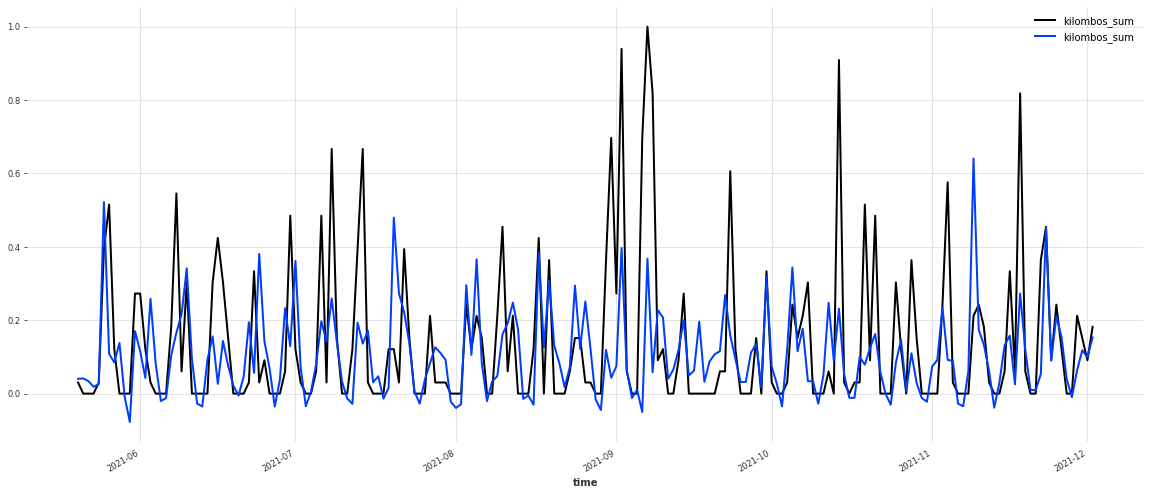

In [ ]:
pred = model.predict(series=seriesByItem['train']['target'][0], past_covariates=seriesByItem['train']['past_covars'][0].append(seriesByItem['test']['past_covars'][0]), n=len(seriesByItem['test']['target'][0]))

plt.figure(figsize=(20, 8))
seriesByItem['test']['target'][0].plot()
pred.plot()

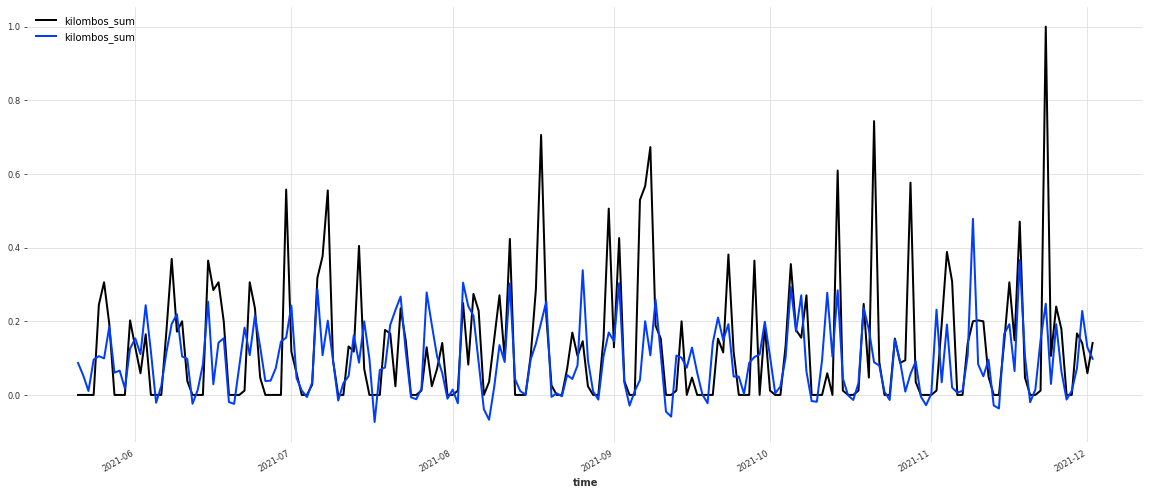

In [ ]:
itemTimeSeries = filler.transform(dailySeries)
# Escalamos la serie
scaled_series = scaler.transform(itemTimeSeries)
train, test = scaled_series.split_before(.8)
# Separamos las covariantes
daily_scaled_train_covs = concatenate(
    [
        train['kilombos_max'],
        train['kilombos_std'],
        train['kilombos_median'],
    ],
    axis="component",
)
daily_scaled_test_covs = concatenate(
    [
        test['kilombos_max'],
        test['kilombos_std'],
        test['kilombos_median'],
    ],
    axis="component",
)
# predecimos
pred = model.predict(series=train['kilombos_sum'], past_covariates=daily_scaled_train_covs.append(daily_scaled_test_covs), n=len(test['kilombos_sum']))
plt.figure(figsize=(20, 8))
test['kilombos_sum'].plot()
pred.plot()

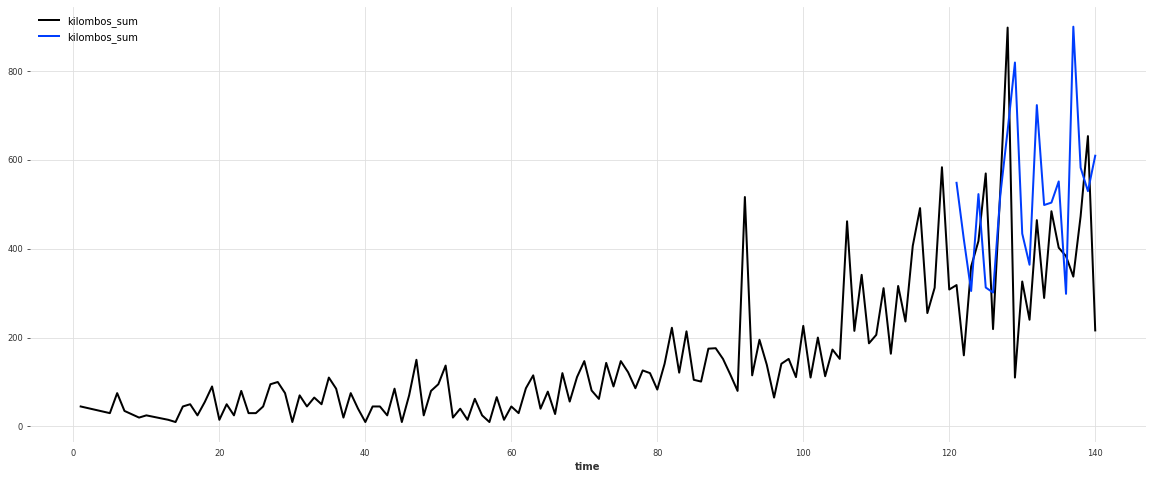

In [ ]:
pred = model.predict(series=train['kilombos_sum'], n=len(test))
plt.figure(figsize=(20, 8))
series['kilombos_sum'].plot()
pred.plot()

In [ ]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts import concatenate
# Reemplazamos los valores faltantes
filler = MissingValuesFiller(fill=0.)
scaled_series = filler.transform(series)
# Escalamos la serie
scaled_series = Scaler().fit_transform(scaled_series)
scaled_covs = concatenate(
    [
        scaled_series['kilombos_max'],
        scaled_series['kilombos_mean'],
        scaled_series['kilombos_median'],
    ],
    axis="component",
)

scaled_train, scaled_test = scaled_series['kilombos_sum'].split_before(getSeparationIndex(groupedDaily))
# Entrenamos un N-BEATS
scaled_model = NBEATSModel(input_chunk_length=60, output_chunk_length=30, random_state=42)
scaled_model.fit([scaled_train['kilombos_sum']], past_covariates=scaled_covs, val_series=[scaled_test['kilombos_sum']], val_past_covariates=scaled_covs, epochs=50, verbose=True)
# Predecimos y graficamos
pred = scaled_model.predict(series=scaled_train['kilombos_sum'], past_covariates=scaled_covs, n=len(scaled_test))
plt.figure(figsize=(20, 8))
scaled_series['kilombos_sum'].plot()
pred.plot()

NameError: name 'series' is not defined

In [ ]:
filler = MissingValuesFiller(fill=0.)
scaled_series = filler.transform(dailySeries)
scaled_series['kilombos_sum'].head(5)

<TimeSeries (DataArray) (ds: 5, component: 1, sample: 1)>
array([[[40.]],

       [[ 0.]],

       [[ 0.]],

       [[ 5.]],

       [[ 0.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2019-04-02 2019-04-03 ... 2019-04-06
  * component  (component) object 'kilombos_sum'
Dimensions without coordinates: sample

In [ ]:
prophetDf = groupedDaily.reset_index().rename(columns={'kilombos_sum': 'y'}).drop(columns=['cod_cliente_nunique', 'cod_vendedor_nunique'])
# prophetDf['cap'] = 150
m = Prophet().add_country_holidays(country_name='CL')
m.fit(prophetDf)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


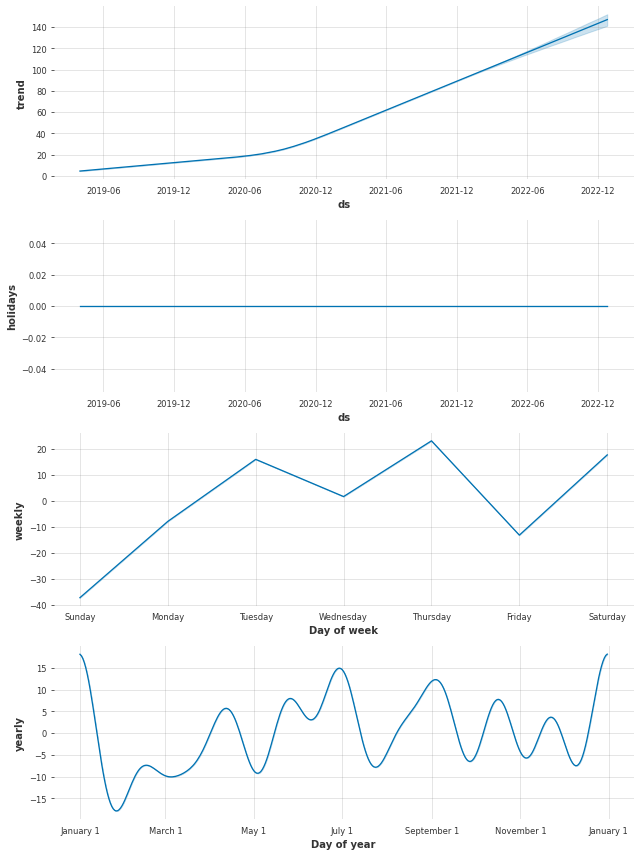

In [ ]:
future = m.make_future_dataframe(periods=56, freq='W')
# future['cap'] = 300
forecast = m.predict(future)
fig1 = m.plot_components(forecast)
